In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn

import emmental

from emmental.data import EmmentalDataLoader, EmmentalDataset
from emmental.emmental_model import EmmentalModel
from emmental.learner import EmmentalLearner
from emmental.task import Task
from emmental.scorer import Scorer

In [3]:
emmental.init_logging("test_run")

[2019-04-19 13:11:54,350][INFO] emmental.meta:44 - Setting logging directory to: test_run/2019_04_19/13_11_54


### Generate data

In [4]:
N = 200
X = np.random.random((N, 2)) * 2 - 1
Y = (X[:, 0] > X[:, 1] + 0.25).astype(int) + 1

In [5]:
# categorical labels: 
Y1_mask = Y == 1
Y2_mask = Y == 2

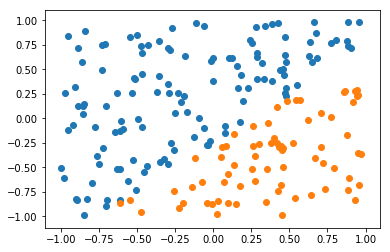

In [6]:
plt.scatter(X[Y1_mask, 0], X[Y1_mask, 1])
plt.scatter(X[Y2_mask, 0], X[Y2_mask, 1])
plt.show()

### Load config

In [7]:
from emmental.utils.config import load_config

In [8]:
config = load_config()

In [9]:
config

{'model_config': {'seed': None,
  'verbose': True,
  'device': 0,
  'fp16': False,
  'model_path': None},
 'learner_config': {'seed': None,
  'verbose': True,
  'progress_bar': True,
  'n_epochs': 1,
  'train_split': 'train',
  'valid_split': 'valid',
  'test_split': 'test',
  'optimizer_config': {'optimizer': 'adam',
   'lr': 0.001,
   'l2': 0.0,
   'grad_clip': 1.0,
   'sgd_config': {'momentum': 0.9},
   'adam_config': {'betas': (0.9, 0.999)}},
  'lr_scheduler_config': {'lr_scheduler': None,
   'warmup_steps': 0.0,
   'warmup_unit': 'epoch',
   'min_lr': 0.0,
   'linear_config': {'min_lr': 0.0},
   'exponential_config': {'gamma': 0.9},
   'plateau_config': {'factor': 0.5, 'patience': 10, 'threshold': 0.0001}},
  'task_scheduler': 'sequential'},
 'logging_config': {'counter_unit': 'batch',
  'evaluation_freq': 10,
  'writer_config': {'writer': 'tensorboard', 'verbose': True},
  'checkpointint': True,
  'checkpointer_config': {'checkpoint_path': None,
   'checkpoint_freq': 2,
   'check

### Create tasks

In [10]:
def mse_loss(immediate_ouput, Y):
    mse = nn.MSELoss()
    return mse(immediate_ouput[-1][0].view(-1), Y.view(-1))

In [11]:
def ce_loss(immediate_ouput, Y):
#     F.cross_entropy(X["data"], Y.view(-1) - 1))
#     ce = nn.BCELoss()
#     print(immediate_ouput[-1][0].size(), Y.size())
    return F.cross_entropy(immediate_ouput[-1][0], Y.view(-1) - 1)

In [12]:
def output(immediate_ouput):
    return immediate_ouput[-1][0]

In [13]:
task1 = Task(
    name="task1",
    module_pool=nn.ModuleDict(
        {
            "input_module": nn.Linear(2, 8),
            "middle_module": nn.Linear(8, 8),
            "head_module1": nn.Linear(8, 2),
        }
    ),
    task_flow=[
        {"module": "input_module", "inputs": [(0, 'data')]},
        {"module": "middle_module", "inputs": [(1, 0)]},
        {"module": "head_module1", "inputs": [(2, 0)]},
    ],
    loss_func=ce_loss,
    output_func=output,
    scorer=Scorer(metrics=['f1', 'accuracy']),
)

[2019-04-19 13:11:54,783][INFO] emmental.task:34 - Created task: task1


In [14]:
task2 = Task(
    name="task2",
    module_pool=nn.ModuleDict(
        {
            "input_module": nn.Linear(2, 8),
            "middle_module": nn.Linear(8, 8),
            "head_module2": nn.Linear(8, 2),
        }
    ),
    task_flow=[
        {"module": "input_module", "inputs": [(0, 'data')]},
        {"module": "middle_module", "inputs": [(1, 0)]},
        {"module": "head_module2", "inputs": [(2, 0)]},
    ],
    loss_func=ce_loss,
    output_func=output,
    scorer=Scorer(metrics=['f1', 'accuracy']),
)

[2019-04-19 13:11:54,811][INFO] emmental.task:34 - Created task: task2


In [15]:
mtl_model = EmmentalModel(name = 'all', config = config, tasks=[task1, task2])

[2019-04-19 13:11:54,840][INFO] emmental.emmental_model:43 - Created emmental model all that contains task {'task2', 'task1'}.
[2019-04-19 13:11:54,841][INFO] emmental.emmental_model:60 - No cuda device available. Switch to cpu instead.


0
False


In [16]:
import torch
torch.cuda.is_available()

False

In [17]:
# mtl_model1 = EmmentalModel(name = 'all', tasks=[task1, task1])

### Generate dataloader

In [18]:
splits = [0.8, 0.1, 0.1]

X_train, X_dev, X_test = [], [], []
Y_train, Y_dev, Y_test = [], [], []

for i in range(N):
    if i <= N * splits[0]:
        X_train.append(torch.Tensor(X[i]))
        Y_train.append(torch.Tensor([Y[i]]).type(torch.LongTensor))
    elif i < N * (splits[0] + splits[1]):
        X_dev.append(torch.Tensor(X[i]))
        Y_dev.append(torch.Tensor([Y[i]]).type(torch.LongTensor))
    else:
        X_test.append(torch.Tensor(X[i]))
        Y_test.append(torch.Tensor([Y[i]]).type(torch.LongTensor))

In [19]:
train_dataset = EmmentalDataset(name="da1", X_dict={"data": X_train}, Y_dict={"label": Y_train})
dev_dataset = EmmentalDataset(name="da1", X_dict= {"data": X_dev}, Y_dict={"label": Y_dev})
test_dataset = EmmentalDataset(name="da1", X_dict= {"data": X_test}, Y_dict={"label": Y_test})

In [20]:
train_dataloader1 = EmmentalDataLoader(
    task_name="task1", dataset=train_dataset, label_name="label", split="train", batch_size=10
)
dev_dataloader1 = EmmentalDataLoader(
    task_name="task1", dataset=dev_dataset, label_name="label", split="valid", batch_size=10
)
test_dataloader1 = EmmentalDataLoader(
    task_name="task1", dataset=test_dataset, label_name="label", split="test", batch_size=10
)

In [21]:
train_dataloader2 = EmmentalDataLoader(
    task_name="task2", dataset=train_dataset, label_name="label", split="train", batch_size=20
)
dev_dataloader2 = EmmentalDataLoader(
    task_name="task2", dataset=dev_dataset, label_name="label", split="valid", batch_size=10
)
test_dataloader2 = EmmentalDataLoader(
    task_name="task2", dataset=test_dataset, label_name="label", split="test", batch_size=10
)

In [22]:
emmental_learner = EmmentalLearner(config)

In [23]:
new_config = {"learner_config": {"n_epochs": 10, "optimizer_config": {"lr": 0.01}}}

In [24]:
emmental_learner.learn(mtl_model, [train_dataloader1, train_dataloader2, dev_dataloader1, dev_dataloader2], config=new_config)

[2019-04-19 13:11:55,100][INFO] emmental.utils.logging.logging_manager:34 - Evaluating every 10 batch.
[2019-04-19 13:11:55,101][INFO] emmental.utils.logging.logging_manager:41 - Checkpointing every 20 batch.
[2019-04-19 13:11:55,111][INFO] emmental.utils.logging.checkpointer:49 - Save checkpoints at test_run/2019_04_19/13_11_54 every 20 batch
[2019-04-19 13:11:55,112][INFO] emmental.utils.logging.checkpointer:73 - No checkpoints saved before 0 batch.
[2019-04-19 13:11:55,113][INFO] emmental.learner:277 - Start learning...


[2019-04-19 13:11:55,191][INFO] emmental.utils.logging.checkpointer:95 - Save checkpoint of 20 batch at test_run/2019_04_19/13_11_54/checkpoint_20.pth.
[2019-04-19 13:11:55,193][INFO] emmental.utils.logging.checkpointer:109 - Save best model of metric task1/da1/valid/f1 at test_run/2019_04_19/13_11_54/best_model_task1_da1_valid_f1.pth


[2019-04-19 13:11:55,278][INFO] emmental.utils.logging.checkpointer:95 - Save checkpoint of 40 batch at test_run/2019_04_19/13_11_54/checkpoint_40.pth.
[2019-04-19 13:11:55,279][INFO] emmental.utils.logging.checkpointer:109 - Save best model of metric task1/da1/valid/f1 at test_run/2019_04_19/13_11_54/best_model_task1_da1_valid_f1.pth


[2019-04-19 13:11:55,370][INFO] emmental.utils.logging.checkpointer:95 - Save checkpoint of 60 batch at test_run/2019_04_19/13_11_54/checkpoint_60.pth.


[2019-04-19 13:11:55,448][INFO] emmental.utils.logging.checkpointer:95 - Save checkpoint of 80 batch at test_run/2019_04_19/13_11_54/checkpoint_80.pth.
[2019-04-19 13:11:55,500][INFO] emmental.utils.logging.checkpointer:95 - Save checkpoint of 100 batch at test_run/2019_04_19/13_11_54/checkpoint_100.pth.


[2019-04-19 13:11:55,572][INFO] emmental.utils.logging.checkpointer:95 - Save checkpoint of 120 batch at test_run/2019_04_19/13_11_54/checkpoint_120.pth.


[2019-04-19 13:11:55,645][INFO] emmental.utils.logging.checkpointer:95 - Save checkpoint of 140 batch at test_run/2019_04_19/13_11_54/checkpoint_140.pth.


[2019-04-19 13:11:55,712][INFO] emmental.utils.logging.checkpointer:95 - Save checkpoint of 160 batch at test_run/2019_04_19/13_11_54/checkpoint_160.pth.
[2019-04-19 13:11:55,762][INFO] emmental.utils.logging.checkpointer:95 - Save checkpoint of 180 batch at test_run/2019_04_19/13_11_54/checkpoint_180.pth.


[2019-04-19 13:11:55,832][INFO] emmental.utils.logging.checkpointer:95 - Save checkpoint of 200 batch at test_run/2019_04_19/13_11_54/checkpoint_200.pth.


[2019-04-19 13:11:55,904][INFO] emmental.utils.logging.checkpointer:95 - Save checkpoint of 220 batch at test_run/2019_04_19/13_11_54/checkpoint_220.pth.


[2019-04-19 13:11:55,977][INFO] emmental.utils.logging.checkpointer:95 - Save checkpoint of 240 batch at test_run/2019_04_19/13_11_54/checkpoint_240.pth.
[2019-04-19 13:11:56,028][INFO] emmental.utils.logging.checkpointer:95 - Save checkpoint of 260 batch at test_run/2019_04_19/13_11_54/checkpoint_260.pth.


In [25]:
for x, y in train_dataloader1:
    print(len(next(iter(y.values()))))
    res = mtl_model._calculate_probs(x, [train_dataloader1.task_name])
    print(res, res['task1'].shape)

10
{'task1': array([[ -5.605821 ,   6.616453 ],
       [ 10.115773 , -12.303732 ],
       [ -5.1620855,   6.041027 ],
       [ 18.612885 , -22.665606 ],
       [  4.6857123,  -5.976761 ],
       [  5.3827314,  -6.5714474],
       [  9.706847 , -11.994118 ],
       [-13.425292 ,  16.08996  ],
       [ -3.8153324,   4.383479 ],
       [ -5.8330665,   6.939002 ]], dtype=float32)} (10, 2)
10
{'task1': array([[ 11.523288 , -14.127176 ],
       [ -7.124387 ,   8.5031595],
       [ 16.296492 , -19.879707 ],
       [ -7.7682495,   9.283152 ],
       [ 13.096664 , -15.87392  ],
       [ 14.56792  , -17.637539 ],
       [  5.5487957,  -6.8551826],
       [ 13.86955  , -16.925653 ],
       [ 22.386166 , -27.18903  ],
       [ 11.763883 , -14.364275 ]], dtype=float32)} (10, 2)
10
{'task1': array([[ 31.00486  , -37.645245 ],
       [ -9.577427 ,  11.440399 ],
       [ 10.621839 , -12.981565 ],
       [  3.413901 ,  -4.131667 ],
       [ -6.221949 ,   7.385564 ],
       [ -1.4887195,   1.6450294],
 

In [26]:
mtl_model.predict(train_dataloader1, return_preds=True)

(defaultdict(list,
             {'task1': array([2, 1, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2,
                     1, 1, 2, 2, 1, 1, 2, 1, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2,
                     2, 1, 1, 2, 2, 1, 1, 2, 2, 1, 1, 1, 2, 1, 2, 1, 1, 2, 2, 1, 1, 1,
                     1, 2, 2, 2, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1,
                     2, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 2, 1, 2, 1, 2, 1,
                     1, 1, 1, 2, 2, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1,
                     2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1,
                     1, 1, 1, 2, 1, 2, 1])}),
 defaultdict(list, {'task1': array([[ -5.605821  ,   6.616453  ],
                     [ 10.115773  , -12.303732  ],
                     [ -5.1620855 ,   6.041027  ],
                     [ 18.612885  , -22.665606  ],
                     [  4.6857123 ,  -5.976761  ],
                     [  5.3827314 ,  -6.5714474

In [27]:
mtl_model.score(train_dataloader1)

{'task1/da1/train/f1': 1.0, 'task1/da1/train/accuracy': 1.0}

In [28]:
from collections.abc import Iterable

isinstance(train_dataloader1, list)

False

In [29]:
a = np.array([1,0,1,0,1,0])
b = np.array([1,1,1,1,1,0])

In [30]:
from emmental.metrics.accuracy import accuracy_scorer
from emmental.metrics.fbeta import f1_scorer, fbeta_scorer
from emmental.metrics.precision import precision_scorer
from emmental.metrics.recall import recall_scorer

In [31]:
accuracy_scorer(a, b, b)

{'accuracy': 0.6666666666666666}

In [32]:
from emmental.metrics import METRICS

In [33]:
METRICS

{'accuracy': <function emmental.metrics.accuracy.accuracy_scorer(gold, probs, preds, normalize=True)>,
 'precision': <function emmental.metrics.precision.precision_scorer(gold, probs, preds, pos_label=1)>,
 'recall': <function emmental.metrics.recall.recall_scorer(gold, probs, preds, pos_label=1)>,
 'f1': <function emmental.metrics.fbeta.f1_scorer(gold, probs, preds, pos_label=1)>,
 'fbeta': <function emmental.metrics.fbeta.fbeta_scorer(gold, probs, preds, pos_label=1, beta=1)>,
 'matthews_correlation': <function emmental.metrics.matthews_correlation.matthews_correlation_coefficient_scorer(gold, probs, preds)>,
 'mean_squared_error': <function emmental.metrics.mean_squared_error.mean_squared_error_scorer(gold, probs, preds)>,
 'pearson_correlation': <function emmental.metrics.pearson_correlation.pearson_correlation_scorer(gold, probs, preds)>,
 'pearson_spearman': <function emmental.metrics.pearson_spearman.pearson_spearman_scorer(gold, probs, preds)>,
 'spearman_correlation': <functio

In [34]:
METRICS["accuracy"](a,b,b)

{'accuracy': 0.6666666666666666}

In [35]:
c = ['1', '2', '3', '4']
d = ['1', '1', '1', '1']

In [36]:
np.where(a == b)[0]

array([0, 2, 4, 5])

In [37]:
np.where([a == b])

(array([0, 0, 0, 0]), array([0, 2, 4, 5]))

In [38]:
np.where(c == d)
# np.where([c == d])

(array([], dtype=int64),)

In [39]:
np.where(a == b)[0].shape[0]

4

In [40]:
2/3

0.6666666666666666

In [41]:
precision_scorer(b, a, a)

{'precision': 1.0}

In [42]:
recall_scorer(b, a, a)

{'recall': 0.6}

In [43]:
f1_scorer(b,a,a)

{'f1': 0.7499999999999999}

In [44]:
from emmental.metrics import METRICS

metrics = METRICS

golds = np.array([1,0,1,0,1,0])
preds = np.array([1,1,1,1,1,0])
probs = np.array([0.8,0.6,0.9,0.7,0.7,0.2])

res = dict()

for metric_name, metric in metrics.items():
    res.update(metric(golds, probs, preds))

# res = {metric_name: metric(golds, preds, probs) for metric_name, metric in metrics.items()}

{'pearson_correlation': 0.4472135954999579, 'pearson_pvalue': 0.37390096630005887, 'spearman_correlation': 0.447213595499958, 'spearman_pvalue': 0.3739009663000589}


In [45]:
res

{'accuracy': 0.6666666666666666,
 'precision': 0.6,
 'recall': 1.0,
 'f1': 0.7499999999999999,
 'matthews_corrcoef': 0.4472135954999579,
 'mean_squared_error': 0.17166666666666666,
 'pearson_correlation': 0.4472135954999579,
 'pearson_pvalue': 0.37390096630005887,
 'spearman_correlation': 0.447213595499958,
 'spearman_pvalue': 0.3739009663000589,
 'pearson_spearman': 0.447213595499958}

In [46]:
metrics['f1'](golds, preds, probs)

{'f1': 0.0}

In [47]:
from emmental.scorer import Scorer

In [48]:
def sum(gold, preds, probs):
    return np.sum(preds)

In [49]:
scorer = Scorer(metrics=['accuracy', 'f1'], customize_metric_funcs={"sum": sum})

In [50]:
scorer.score(golds, preds, probs)

{'accuracy': 0.0, 'f1': 0.0, 'sum': 5}

In [51]:
len(train_dataloader1.dataset)

161